In [1]:
import scipy as sp
import numpy as np
#import pylab as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import find_peaks


#so, we have to completely rewrite the code, and basically do what he told us to do at the beginning, DISCRETIZE!!!

def FHNneuron(I,timespan,dt,point):
    #parameters
    #would be nice to explain what each param means
    a=0.7
    b=0.8
    c=3
    
    #these two params from scholarpedia, would like better justification
    R=1
    tauinv=0.08*3 #1/tau
    t=np.arange(0.0, timespan, dt)
    
    #lets add noise with some modulation by a constant 0<k<1;
    k1=0.1
    k2=0.1
    
    v=np.zeros(len(t))
    w=np.zeros(len(t))
    
    v[0]=point[0]
    w[0]=point[1]
    
    for i in range (len(t)-1):
        v[i+1]=v[i]+dt*(v[i]-(v[i]**3)/3 - w[i] + R*I)
        w[i+1]=w[i]+dt*((tauinv/c)*(v[i] + a - b*w[i]))
    
    return v,w

In [2]:
def FHNneuronNoisy(I,timespan,dt,point,k1,k2):
    #parameters
    #would be nice to explain what each param means
    a=0.7
    b=0.8
    c=3
    
    #these two params from scholarpedia, would like better justification
    R=1
    tauinv=0.08*3 #1/tau
    t=np.arange(0.0, timespan, dt)
    
    #lets add noise with some modulation by a constant k1,k2
    
    noise1=k1*np.sqrt(dt)*np.random.normal(0,1,len(t))
    noise2=k2*np.sqrt(dt)*np.random.normal(0,1,len(t))
    
    v=np.zeros(len(t))
    w=np.zeros(len(t))
    
    v[0]=point[0]
    w[0]=point[1]
    
    for i in range (len(t)-1):
        v[i+1]=v[i]+dt*(v[i]-(v[i]**3)/3 - w[i] + R*I)   + noise1[i]
        w[i+1]=w[i]+dt*((tauinv/c)*(v[i] + a - b*w[i])) + noise2[i]
    
    return v,w

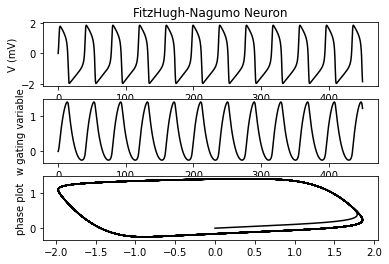

In [3]:
I=0.5;
tstop=450;
dt=0.01
t=np.arange(0.0, tstop, dt)
neuron1=FHNneuron(I,tstop,dt,[0,0]);
v=neuron1[0];
w=neuron1[1];

plt.figure()

plt.subplot(3,1,1)
plt.title('FitzHugh-Nagumo Neuron')
plt.plot(t, v, 'k')
plt.ylabel('V (mV)')

plt.subplot(3,1,2)
plt.plot(t, w, 'k')
plt.ylabel('w gating variable')

plt.subplot(3,1,3)
plt.plot(v, w, 'k')
plt.ylabel('phase plot')

plt.show()    
    

(-0.5, 2.0)

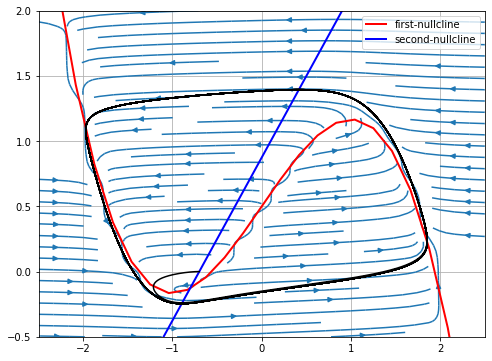

In [4]:
#for this, pick Iext
Iext=0.5;
tstop=450;
dt=0.01
t=np.arange(0.0, tstop, dt)

fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);

a=0.7
b=0.8
c=3

def Syst(X,Iext): #without time
    a=0.7
    b=0.8
    c=3
    #these two params from scholarpedia, would like better justification
    R=1
    tauinv=0.08 #1/tau
    """
    Integrate

    |  :param X:
    |  :param t:
    |  :return: calculate membrane potential & activation variables
    """
        
    v, w = X
        
    dvdt = v - (v**3)/3 - w + R*Iext
    dwdt = +(tauinv/c)*(v + a - b*w)
        
    return dvdt, dwdt

def w1(v,Iext):
    return (v - (v**3)/3 + Iext)

def w2(v,Iext):
    return (v + a)/b

ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
va=neuron[0];
wa=neuron[1];
ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M

ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()
plt.xlim(-2.5,2.5)
plt.ylim(-0.5,2)

In [5]:
def find_roots(I): #This gives the equilibrium points, given I
    a=0.7
    b=0.8
    coeff=[1/3, 0, 1/b - 1, a/b - I]
    #Only keep real roots:
    roots = [np.real(r) for r in np.roots(coeff) if np.isreal(r)]
    # We store the position of the equilibrium. 
    return [[r, r - (r**3)/3 + I] for r in roots]

In [6]:
def jacobian(point, I): #find jacobian by hand, put equilibrium points into here
    a=0.7
    b=0.8
    c=3
    tau=1/(0.08*3) #1/tau
    v=point[0]
    w=point[1]
    return np.array([[c*(-v**2 + 1) , -c],
                       [1/(c*tau), -b/(c*tau)]])

In [7]:
def stability(jacobian): #Put jacobian into here and it says what kind of point it is, (unchanged)
    eigv = np.linalg.eigvals(jacobian)
    
    if all(np.real(eigv)==0) and all(np.imag(eigv)!=0):
        nature = "Center" 
    elif np.real(eigv)[0]*np.real(eigv)[1]<0:
        nature = "Saddle"
    else: 
        stability = 'Unstable' if all(np.real(eigv)>0) else 'Stable'
        nature = stability + (' focus' if all(np.imag(eigv)!=0) else ' node')
    return nature

In [8]:
find_roots(0.5)[0]

[-0.8048477470083345, -0.131059683760418]

In [9]:
jacobian(find_roots(0.5)[0],0.5)

array([[ 1.05666031, -3.        ],
       [ 0.08      , -0.064     ]])

In [10]:
stability(jacobian(find_roots(0.5)[0],0.5))

'Unstable node'

In [11]:
#IT WORKS!!!!!, so now, can we add these to a graph???

Unstable node
[-0.8048477470083345, -0.131059683760418]


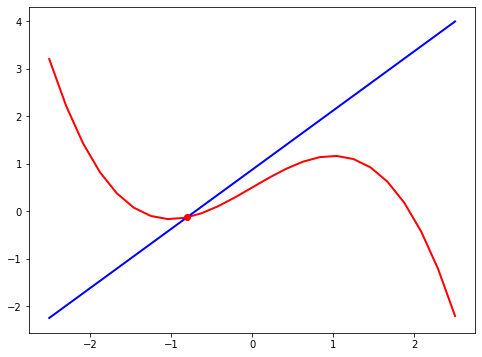

In [12]:
fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);

def find_roots(I): #This gives the equilibrium points, given I
    a=0.7
    b=0.8
    coeff=[1/3, 0, 1/b - 1, a/b - I]
    #Only keep real roots:
    roots = [np.real(r) for r in np.roots(coeff) if np.isreal(r)]
    # We store the position of the equilibrium. 
    return [[r, r - (r**3)/3 + I] for r in roots]

I=0

def w1(v,I):
    return v-(v**3)/3+I

def w2(v,I):
    return (v+a)/b


ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"ro")

In [13]:
#Want to do different color for each kind of stability
#Center - m
#Saddle - y
#Unstable Focus/Node - r/g
#Stable Focus/Node - b/c
def colorize(jacobian): #Put jacobian into here and it says what kind of point it is, (unchanged)
    eigv = np.linalg.eigvals(jacobian)
    if all(np.real(eigv)==0) and all(np.imag(eigv)!=0):
        #nature = "Center" 
        color = "m"
    elif np.real(eigv)[0]*np.real(eigv)[1]<0:
        #nature = "Saddle"
        color = "g"
    elif all(np.real(eigv)>0): #unstable
        if all(np.imag(eigv)!=0):#focus
            color = "y"
        else: #node
            color = "r"
    else: #stable
        if all(np.imag(eigv)!=0):#focus
            color = "c"
        else: #node
            color = "b"        
        #stability = 'Unstable' if all(np.real(eigv)>0) else 'Stable'
        #nature = stability + (' focus' if all(np.imag(eigv)!=0) else ' node')
    return color

Text(0, 0.5, 'v at Fixed Point')

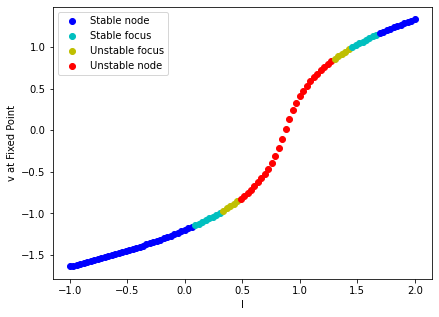

In [74]:
fig2 = plt.figure(figsize=(6.8,5))
ax4 = fig2.add_subplot(1,1,1)

Ivec=np.linspace(-1,2,100)

#data=[];
labels=[];
axlabels=[]
for i in range(len(Ivec)):
    I=Ivec[i]
    roots=find_roots(I)
    for root in roots:
        stab=stability(jacobian(root,Iext))
        color=colorize(jacobian(root,Iext))
        ax4.plot(I,root[0],color+"o",label=stab if stab not in labels else '')
        if stab not in labels:
            labels.append(stab)
            #axlabels.append([color+"o",label])
ax4.legend()
ax4.set_xlabel("I")
ax4.set_ylabel("v at Fixed Point")

In [15]:
I=1.4
root=find_roots(I)[0]
print(stability(jacobian(root,I)))

Unstable focus


-1
1.4
1.6
2


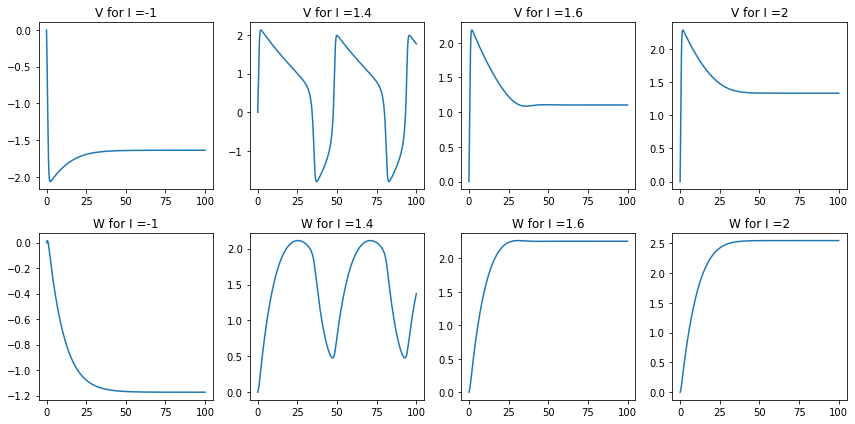

In [16]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];

currents = [-1,1.4,1.6,2];

fig,axs=plt.subplots(2,len(currents),figsize=(12,6)) #,figsize=(12,6)

for i in range(len(currents)):
    I=currents[i]
    neuron=FHNneuron(I,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    axs[0,i].plot(t,va)
    axs[0,i].set_title("V for I ="+str(I))
    axs[1,i].plot(t,wa)
    axs[1,i].set_title("W for I ="+str(I))
    print(I)
    
plt.tight_layout()


Stable node
[-1.6381902176477257, -1.1727377720596568]


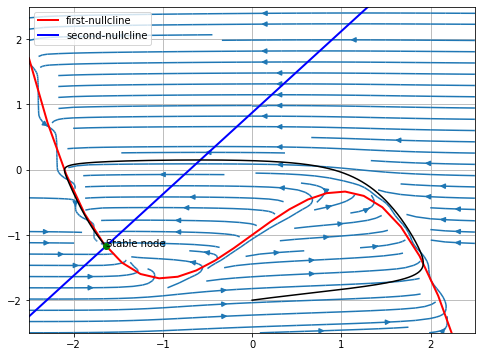

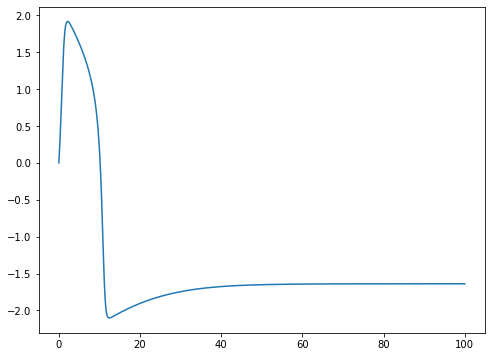

In [17]:
#for this, pick Iext
I=-1;
tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)

fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(-2.5,2.5,25);

ax4.plot(v,w1(v,I),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,I),'b-', lw=2, label='second-nullcline')

neuron=FHNneuron(I,tstop,dt,[0,-2]);
va=neuron[0];
wa=neuron[1];
ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],I)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M

ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(I);
for root in roots:
    label=stability(jacobian(root,I))
    print(label)
    print(root)
    ax4.plot(root[0],root[1],"go")
    ax4.annotate(label,root)



plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)

fig3 = plt.figure(figsize=(8,6))
plt.plot(t,va)

Unstable focus
[0.9514804772489802, 2.0643505965612254]


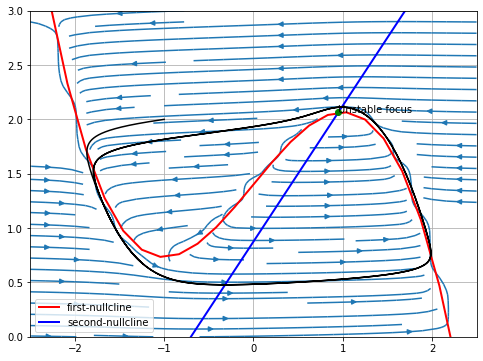

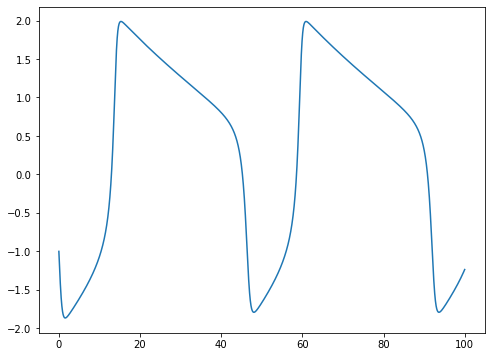

In [18]:
#for this, pick Iext
I=1.4;
tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)

fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(0,3,25);

ax4.plot(v,w1(v,I),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,I),'b-', lw=2, label='second-nullcline')

neuron=FHNneuron(I,tstop,dt,[-1,2]);
va=neuron[0];
wa=neuron[1];
ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],I)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M

ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(I);
for root in roots:
    label=stability(jacobian(root,I))
    print(label)
    print(root)
    ax4.plot(root[0],root[1],"go")
    ax4.annotate(label,root)


plt.xlim(-2.5,2.5)
plt.ylim(0,3)

fig3 = plt.figure(figsize=(8,6))
plt.plot(t,va)

Stable node
[1.3340939878224036, 2.5426174847780048]


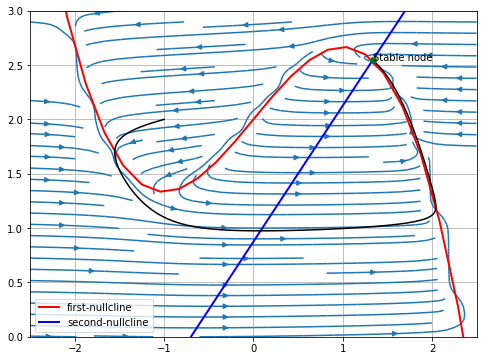

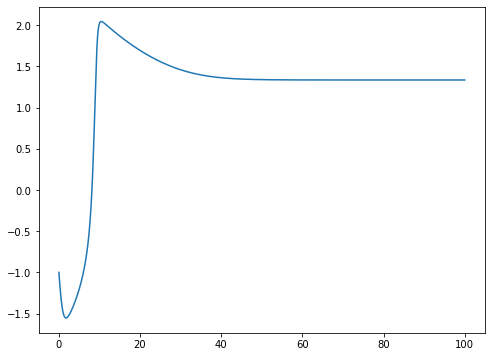

In [19]:
#for this, pick Iext
I=2;
tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)

fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(0,3,25);

ax4.plot(v,w1(v,I),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,I),'b-', lw=2, label='second-nullcline')

neuron=FHNneuron(I,tstop,dt,[-1,2]);
va=neuron[0];
wa=neuron[1];
ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],I)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M

ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(I);
for root in roots:
    label=stability(jacobian(root,I))
    print(label)
    print(root)
    ax4.plot(root[0],root[1],"go")
    ax4.annotate(label,root)


plt.xlim(-2.5,2.5)
plt.ylim(0,3)

fig3 = plt.figure(figsize=(8,6))
plt.plot(t,va)

Unstable node
[0.40886583694341194, 1.386082296179265]


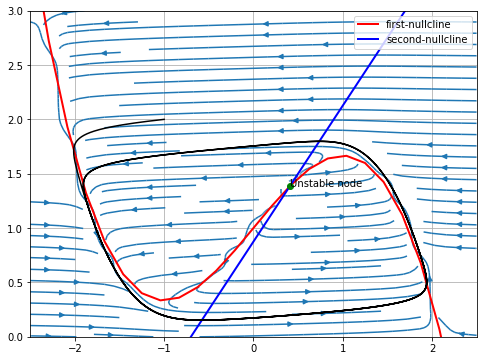

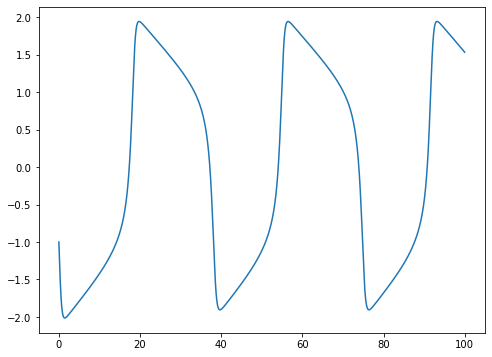

In [20]:
#for this, pick Iext
I=1;
tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)

fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(0,3,25);

ax4.plot(v,w1(v,I),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,I),'b-', lw=2, label='second-nullcline')

neuron=FHNneuron(I,tstop,dt,[-1,2]);
va=neuron[0];
wa=neuron[1];
ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],I)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M

ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(I);
for root in roots:
    label=stability(jacobian(root,I))
    print(label)
    print(root)
    ax4.plot(root[0],root[1],"go")
    ax4.annotate(label,root)


plt.xlim(-2.5,2.5)
plt.ylim(0,3)

fig3 = plt.figure(figsize=(8,6))
plt.plot(t,va)

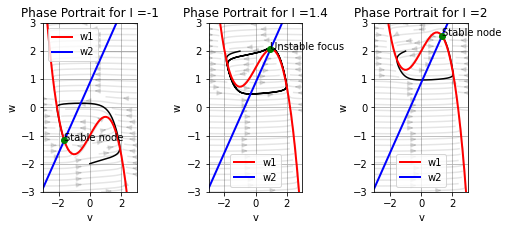

In [108]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];

currents = [-1, 1.4, 2];
points=[[0,-2],[-1,2],[-1,2]]

fig,axs=plt.subplots(1,len(currents),figsize=(6.8,3)) #,figsize=(12,6)
for i in range(len(currents)):
    point=points[i]
    I=currents[i]
    neuron=FHNneuron(I,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];

    axs[i].plot(va,wa,'k-')
    #for this, pick Iext

    #fig2 = plt.figure(figsize=(12,6))
    #ax4 = fig2.add_subplot(1,1,1)

    v=np.linspace(-3,3,50);
    w=np.linspace(-3,3,50);



    axs[i].plot(v,w1(v,I),'r-', lw=2, label='w1')
    axs[i].plot(v,w2(v,I),'b-', lw=2, label='w2')
    

    V1, W1 = np.meshgrid(v, w)
    DV1, DW1 = Syst([V1, W1],I)
    M = (np.hypot(DV1, DW1))
    M[ M == 0] = 1.
    DV1 /= M
    DW1 /= M


    axs[i].streamplot(V1, W1, DV1, DW1,color=(0,0,0,.1))
    axs[i].legend()
    axs[i].grid()

    roots=find_roots(I);
    for root in roots:

        label=stability(jacobian(root,I))
        #print(label)
        #print(root)
        axs[i].plot(root[0],root[1],"go")
        axs[i].annotate(label,root)

    axs[i].set_xlim(-3,3)
    axs[i].set_ylim(-3,3)
    axs[i].set_title("Phase Portrait for I ="+str(I))
    axs[i].set_xlabel('v')
    axs[i].set_ylabel('w')
    axs[i].set
plt.tight_layout(0.01)


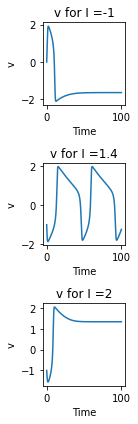

In [109]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];

#currents = [0.25, 0.5, 0.75];
currents = [-1, 1.4, 2];
points=[[0,-2],[-1,2],[-1,2]]

fig,axs=plt.subplots(len(currents),1,figsize=(2,6)) #,figsize=(12,6)

for i in range(len(currents)):
    point=points[i]
    I=currents[i]
    neuron=FHNneuron(I,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    axs[i].plot(t,va)
    axs[i].set_title("v for I ="+str(I))
    #axs[1,i].plot(t,wa)
    #axs[1,i].set_title("W for I ="+str(I))
    #print(I)
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('v')
    
plt.tight_layout()


In [23]:
print(labels)
print(axlabels)

['Stable node', 'Stable focus', 'Unstable focus', 'Unstable node']
[]


In [24]:
x=[1,2,3]
print(x)
np.add(x,2)
print(x)
np.add(x,4)
print(x)

[1, 2, 3]
[1, 2, 3]
[1, 2, 3]


Unstable node
[-0.8048477470083345, -0.131059683760418]


(-0.5, 2.0)

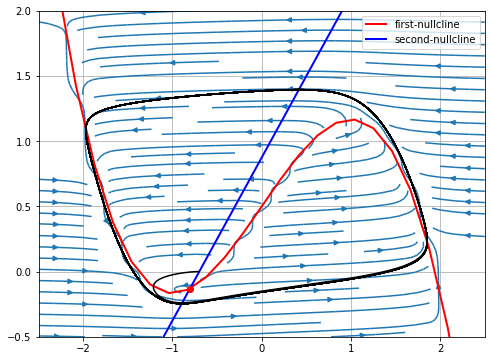

In [25]:
#for this, pick Iext
Iext=0.5;
tstop=450;
dt=0.01
t=np.arange(0.0, tstop, dt)

fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);


a=0.7
b=0.8
c=3


ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')


tstop=450;
dt=0.01
t=np.arange(0.0, tstop, dt)
neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
va=neuron[0];
wa=neuron[1];
ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"ro")

ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()
plt.xlim(-2.5,2.5)
plt.ylim(-0.5,2)

Unstable node
[-0.8048477470083345, -0.131059683760418]


(-0.5, 2.0)

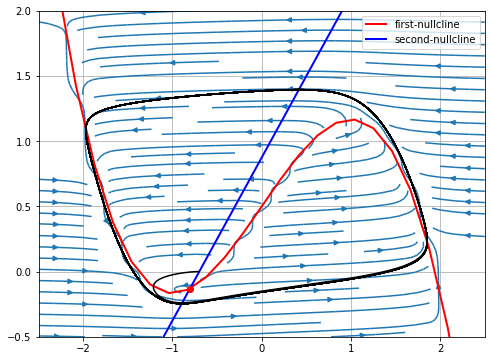

In [26]:
#for this, pick Iext
Iext=0.5;
t=np.arange(0.0, 450.0, 0.01);

fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

tstop=450;
dt=0.01
t=np.arange(0.0, tstop, dt)
neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
va=neuron[0];
wa=neuron[1];
ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"ro")


plt.xlim(-2.5,2.5)
plt.ylim(-0.5,2)

Unstable node
[-0.40886583694341133, 0.3639177038207357]


(-0.5, 2.0)

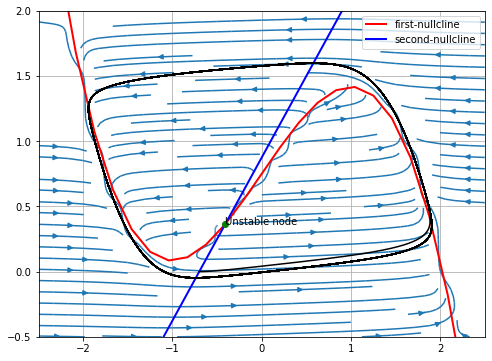

In [27]:
#for this, pick Iext
Iext=0.75;
t=np.arange(0.0, 450.0, 0.01);

fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);


ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

tstop=450;
dt=0.01
t=np.arange(0.0, tstop, dt)
neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
va=neuron[0];
wa=neuron[1];
ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.5,2.5)
plt.ylim(-0.5,2)

Text(0, 0.5, 'V')

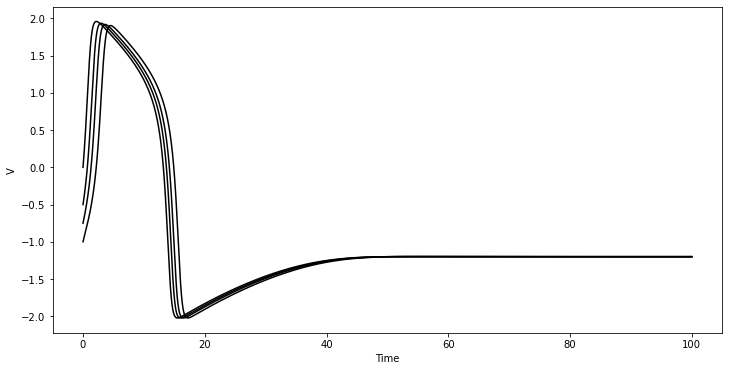

In [28]:
fig3 = plt.figure(figsize=(12,6))
ax5 = fig3.add_subplot(1,1,1)

Iext=0;
tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)

points=[[0,-1],[-0.5,-1],[-0.75,-1],[-1,-1]]

for point in points:
    neuron=FHNneuron(Iext,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    ax5.plot(t,va,'k-')
plt.xlabel('Time')
plt.ylabel('V')

Stable node
[-1.1994080352440346, -0.6242600440550439]


Text(0, 0.5, 'V')

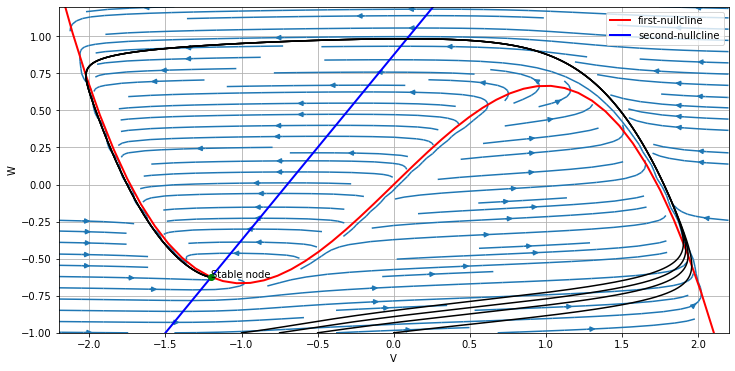

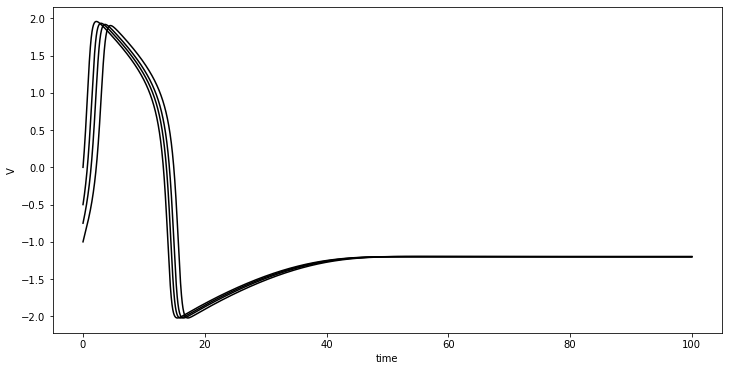

In [29]:
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(12,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)

points=[[0,-1],[-0.5,-1],[-0.75,-1],[-1,-1]]
for point in points:
    neuron=FHNneuron(Iext,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    ax4.plot(va,wa,'k-')

    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('V')
plt.ylabel('W')

fig3 = plt.figure(figsize=(12,6))
ax5 = fig3.add_subplot(1,1,1)

for point in points:
    neuron=FHNneuron(Iext,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    ax5.plot(t,va,'k-')
plt.xlabel('time')
plt.ylabel('V')



0.25
0.5
0.75


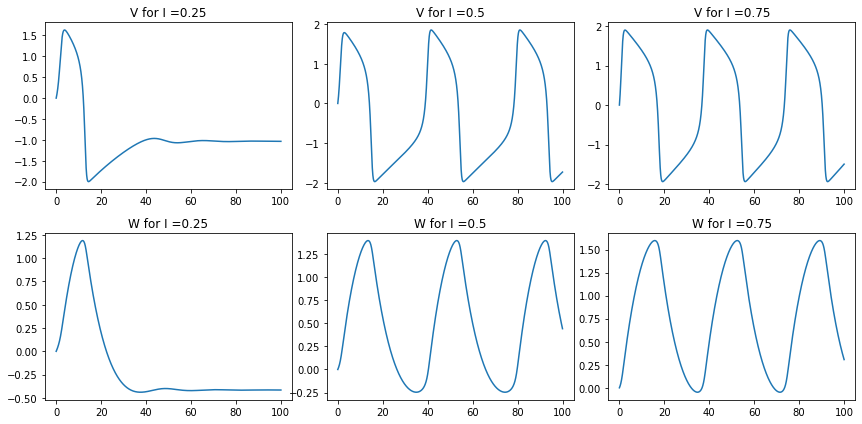

In [30]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];

currents = [0.25, 0.5, 0.75];

fig,axs=plt.subplots(2,len(currents),figsize=(12,6)) #,figsize=(12,6)

for i in range(len(currents)):
    I=currents[i]
    neuron=FHNneuron(I,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    axs[0,i].plot(t,va)
    axs[0,i].set_title("V for I ="+str(I))
    axs[1,i].plot(t,wa)
    axs[1,i].set_title("W for I ="+str(I))
    print(I)
    
plt.tight_layout()


Stable node
[-1.1994080352440346, -0.6242600440550439]


Text(0, 0.5, 'V')

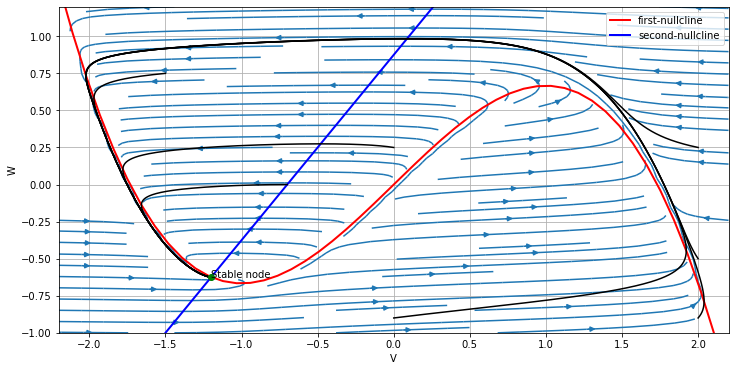

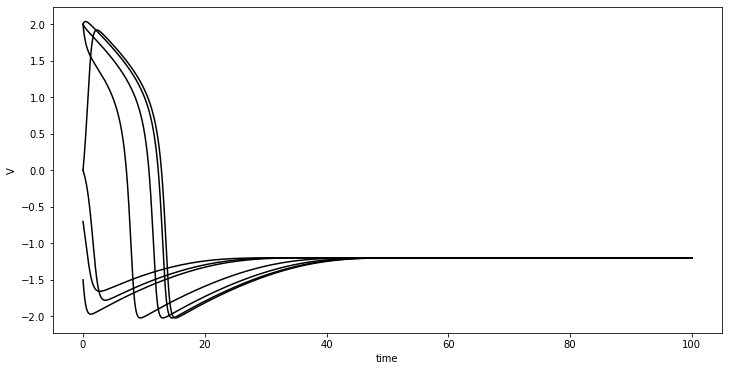

In [31]:
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(12,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)

points=[[0,-0.9],[-0.7,0],[0,0.25],[2,-0.9],[2,-0.5],[-1.5,0.75],[2,0.25]]
for point in points:
    neuron=FHNneuron(Iext,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    ax4.plot(va,wa,'k-')

    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('V')
plt.ylabel('W')

fig3 = plt.figure(figsize=(12,6))
ax5 = fig3.add_subplot(1,1,1)

for point in points:
    neuron=FHNneuron(Iext,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    ax5.plot(t,va,'k-')
plt.xlabel('time')
plt.ylabel('V')



Stable node
[-1.1994080352440346, -0.6242600440550439]


Text(0, 0.5, 'w')

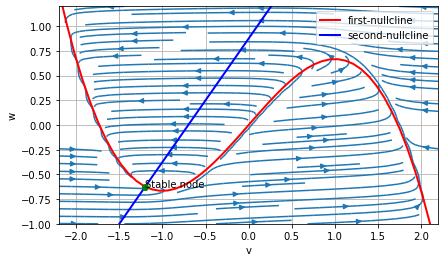

In [51]:
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(6.8,4))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)



    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('v')
plt.ylabel('w')





0.25
0.5
0.75


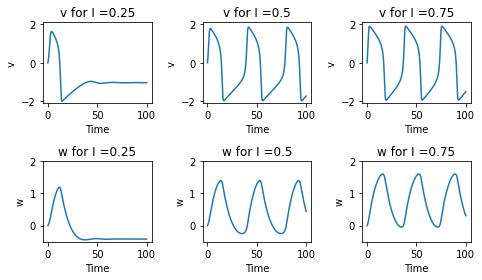

In [63]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];

currents = [0.25, 0.5, 0.75];

fig,axs=plt.subplots(2,len(currents),figsize=(6.8,4)) #,figsize=(12,6)

for i in range(len(currents)):
    I=currents[i]
    neuron=FHNneuron(I,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];
    axs[0,i].plot(t,va)
    axs[0,i].set_title("v for I ="+str(I))
    axs[0,i].set_ylim(-2.1,2.1)
    axs[0,i].set_xlabel("Time")
    axs[0,i].set_ylabel("v")
    axs[1,i].plot(t,wa)
    axs[1,i].set_title("w for I ="+str(I))
    axs[1,i].set_ylim(-0.5,2)
    axs[1,i].set_xlabel("Time")
    axs[1,i].set_ylabel("w")
    print(I)
    
plt.tight_layout()


Stable focus
[-1.0324802239110462, -0.41560027988880766]
Unstable node
[-0.8048477470083345, -0.131059683760418]
Unstable node
[-0.40886583694341133, 0.3639177038207357]


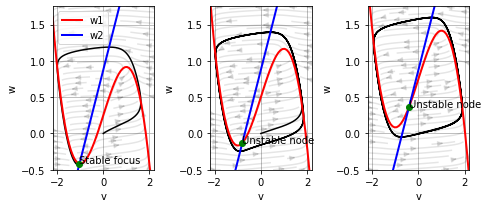

In [70]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
#point=[0,0];

currents = [0.25, 0.5, 0.75];
points=[];

fig,axs=plt.subplots(1,len(currents),figsize=(6.8,3)) #,figsize=(12,6)
for i in range(len(currents)):
    I=currents[i]
    neuron=FHNneuron(I,tstop,dt,point);
    va=neuron[0];
    wa=neuron[1];

    axs[i].plot(va,wa,'k-')
    #for this, pick Iext

    #fig2 = plt.figure(figsize=(12,6))
    #ax4 = fig2.add_subplot(1,1,1)

    v=np.linspace(-2.2,2.2,50);
    w=np.linspace(-0.5,1.75,50);



    axs[i].plot(v,w1(v,I),'r-', lw=2, label='w1')
    axs[i].plot(v,w2(v,I),'b-', lw=2, label='w2')
    

    V1, W1 = np.meshgrid(v, w)
    DV1, DW1 = Syst([V1, W1],I)
    M = (np.hypot(DV1, DW1))
    M[ M == 0] = 1.
    DV1 /= M
    DW1 /= M


    axs[i].streamplot(V1, W1, DV1, DW1,color=(0,0,0,.1))
    axs[0].legend()
    axs[i].grid()

    roots=find_roots(I);
    for root in roots:

        label=stability(jacobian(root,I))
        print(label)
        print(root)
        axs[i].plot(root[0],root[1],"go")
        axs[i].annotate(label,root)

    axs[i].set_xlim(-2.2,2.2)
    axs[i].set_ylim(-0.5,1.75)
    axs[i].set_xlabel('v')
    axs[i].set_ylabel('w')
plt.tight_layout()


Stable node
[-1.1994080352440346, -0.6242600440550439]


Text(0, 0.5, 'V')

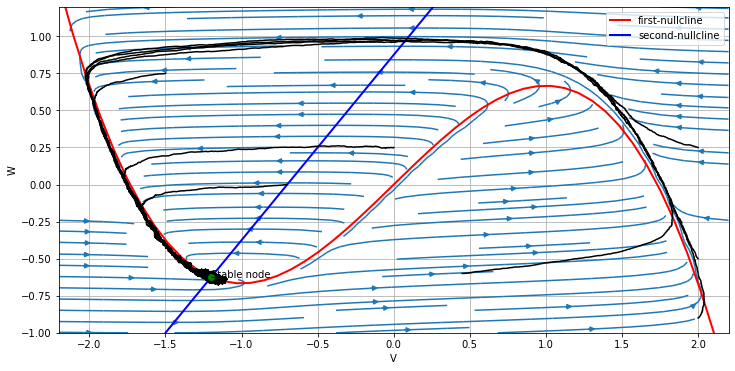

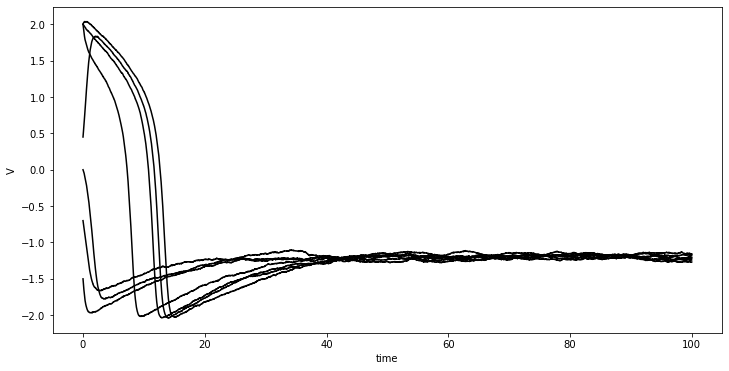

In [35]:
#so now, same general thing for noise levels
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(12,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)

points=[[-0.7,0],[0,0.25],[2,-0.9],[2,-0.5],[-1.5,0.75],[2,0.25],[0.45,-0.6]]
for point in points:
    neuron=FHNneuronNoisy(Iext,tstop,dt,point,0.01,0.01);
    va=neuron[0];
    wa=neuron[1];
    ax4.plot(va,wa,'k-')

    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('V')
plt.ylabel('W')

fig3 = plt.figure(figsize=(12,6))
ax5 = fig3.add_subplot(1,1,1)

for point in points:
    neuron=FHNneuronNoisy(Iext,tstop,dt,point,0.01,0.01);
    va=neuron[0];
    wa=neuron[1];
    ax5.plot(t,va,'k-')
plt.xlabel('time')
plt.ylabel('V')



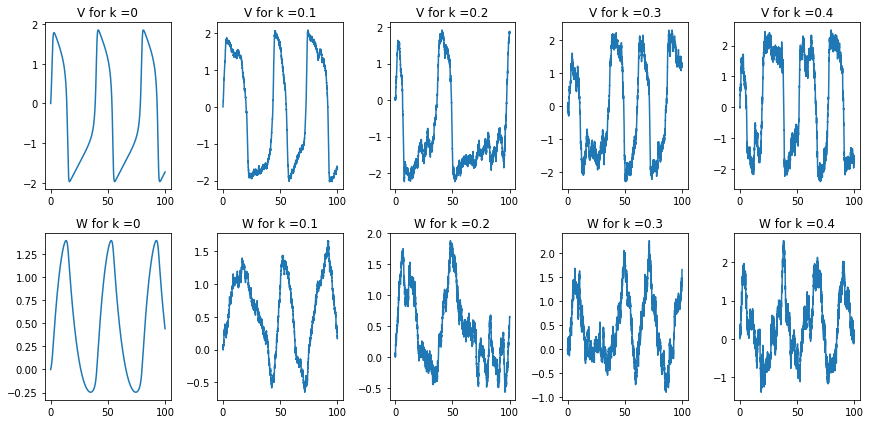

In [36]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];
I=0.5

noises = [0, 0.1, 0.2, 0.3, 0.4];

fig,axs=plt.subplots(2,len(noises),figsize=(12,6)) #,figsize=(12,6)

for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    axs[0,i].plot(t,va)
    axs[0,i].set_title("V for k ="+str(k1))
    axs[1,i].plot(t,wa)
    axs[1,i].set_title("W for k ="+str(k1))
    
plt.tight_layout()


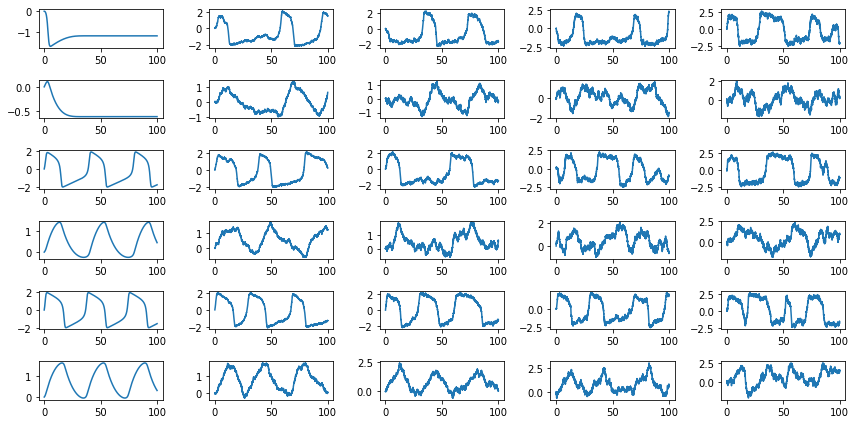

In [37]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];
#I=0.5

noises = [0, 0.1, 0.2, 0.3, 0.4];
currents = [0,0.5,0.75]

fig,axs=plt.subplots(2*len(currents),len(noises),figsize=(12,6)) #,figsize=(12,6)
for j in range(len(currents)):
    for i in range(len(noises)):
        k1=noises[i]
        k2=k1
        I=currents[j]
        neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
        va=neuron[0];
        wa=neuron[1];
        axs[2*j,i].plot(t,va)
        #axs[2*j,i].set_title("V for k ="+str(k1)+" I="+str(I))
        axs[2*j+1,i].plot(t,wa)
        #axs[2*j+1,i].set_title("W for k ="+str(k1)+" I="+str(I))
    
plt.tight_layout()


Unstable node
[-0.8048477470083345, -0.131059683760418]


(-0.5, 2.0)

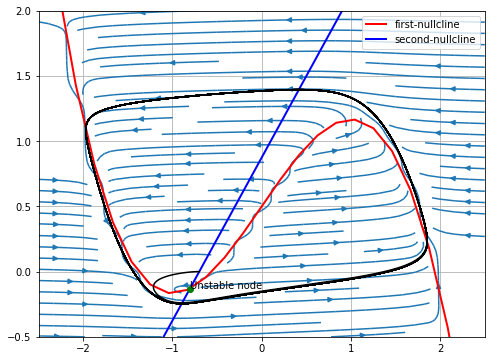

In [38]:
#for this, pick Iext
Iext=0.5;
t=np.arange(0.0, 450.0, 0.01);

fig2 = plt.figure(figsize=(8,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);


ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

tstop=450;
dt=0.01
t=np.arange(0.0, tstop, dt)
neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
va=neuron[0];
wa=neuron[1];
ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.5,2.5)
plt.ylim(-0.5,2)

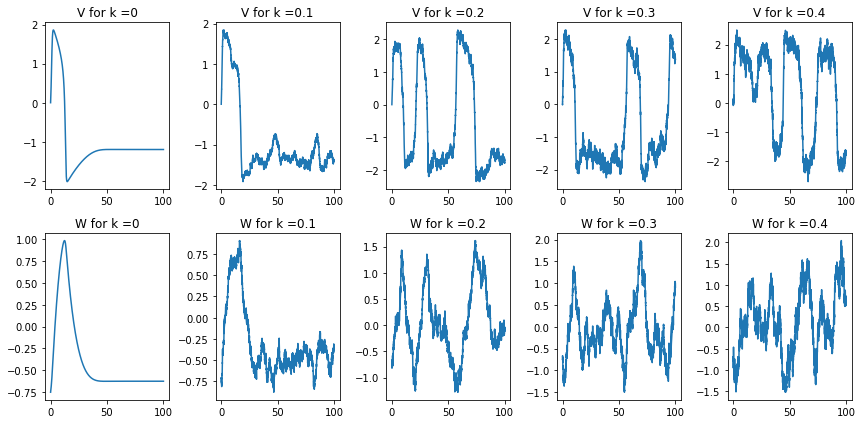

In [39]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,-0.75];
I=0

noises = [0, 0.1, 0.2, 0.3, 0.4];

fig,axs=plt.subplots(2,len(noises),figsize=(12,6)) #,figsize=(12,6)

for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    axs[0,i].plot(t,va)
    axs[0,i].set_title("V for k ="+str(k1))
    axs[1,i].plot(t,wa)
    axs[1,i].set_title("W for k ="+str(k1))
    
plt.tight_layout()


Stable node
[-1.1994080352440346, -0.6242600440550439]


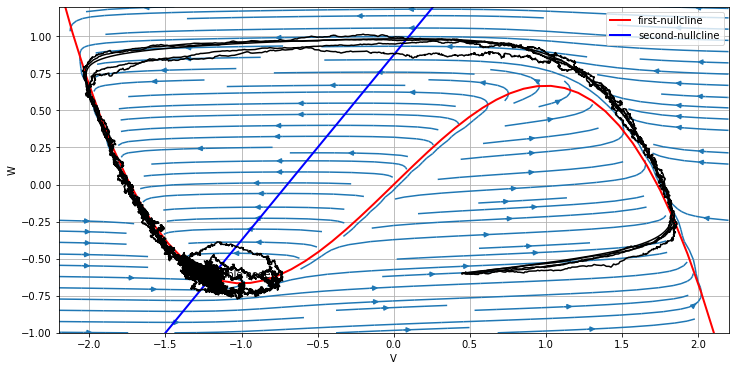

In [40]:
#so now, same general thing for noise levels
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(12,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)



    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('V')
plt.ylabel('W')







tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0.45,-0.6];
I=0

noises = [0, 0.01, 0.02, 0.03, 0.04];


for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    ax4.plot(va,wa,'k-')
    















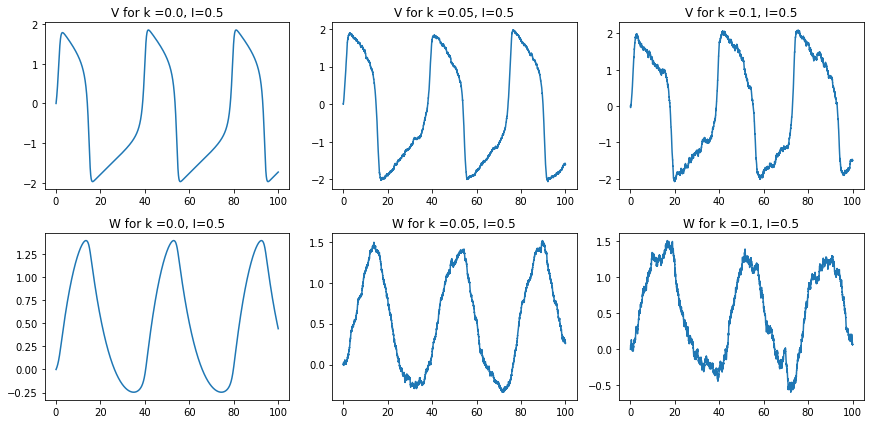

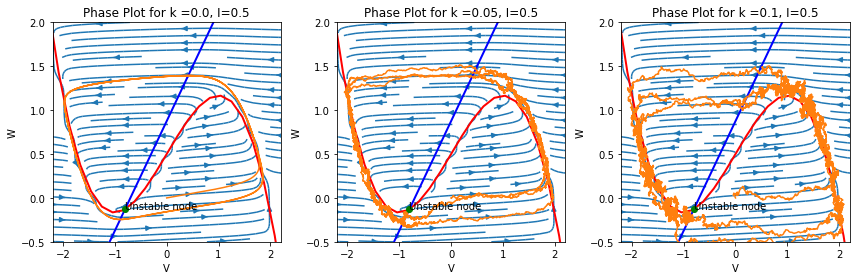

In [41]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];
I=0.5

noises = [0.0, 0.05, 0.1];










fig1,axs1=plt.subplots(2,len(noises),figsize=(12,6)) #,figsize=(12,6)
fig2,axs2=plt.subplots(1,len(noises),figsize=(12,4)) #,figsize=(12,6)


v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],I)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M




for i in range(len(noises)):
    
    

    
    axs2[i].streamplot(V1, W1, DV1, DW1)
    axs2[i].plot(v,w1(v,I),'r-', lw=2, label='first-nullcline')
    axs2[i].plot(v,w2(v,I),'b-', lw=2, label='second-nullcline')
    
    
    
    
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    
    axs1[0,i].plot(t,va)
    axs1[0,i].set_title("V for k ="+str(k1)+", I="+str(I))
    axs1[1,i].plot(t,wa)
    axs1[1,i].set_title("W for k ="+str(k1)+", I="+str(I))    
    
    
    axs2[i].plot(va,wa)
    axs2[i].set_title("Phase Plot for k ="+str(k1)+", I="+str(I))
    
    
    
    
    
    roots=find_roots(I);
    for root in roots:
        label=stability(jacobian(root,I))
        #print(label)
        #print(root)
        axs2[i].plot(root[0],root[1],"go")
        axs2[i].annotate(label,root)
    
    
    
    axs2[i].set_xlim(-2.2,2.2)
    axs2[i].set_ylim(-0.5,2)
    axs2[i].set_xlabel('V')
    axs2[i].set_ylabel('W')
    

    
    
    
    
fig1.tight_layout()
fig2.tight_layout()




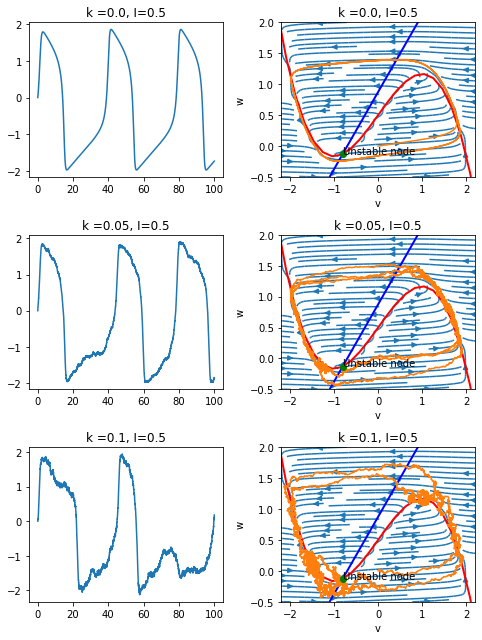

In [115]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];
I=0.5

noises = [0.0, 0.05, 0.1];










fig1,axs1=plt.subplots(len(noises),2,figsize=(6.8,9)) #,figsize=(12,6)
#fig2,axs2=plt.subplots(1,len(noises),figsize=(12,3)) #,figsize=(12,6)


v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],I)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M




for i in range(len(noises)):
    
    

    
    axs1[i,1].streamplot(V1, W1, DV1, DW1)
    axs1[i,1].plot(v,w1(v,I),'r-', lw=2, label='first-nullcline')
    axs1[i,1].plot(v,w2(v,I),'b-', lw=2, label='second-nullcline')
    
    
    
    
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    
    axs1[i,0].plot(t,va)
    axs1[i,0].set_title("k ="+str(k1)+", I="+str(I))
    #axs1[1,i].plot(t,wa)
    #axs1[1,i].set_title("W for k ="+str(k1)+", I="+str(I))    
    
    
    axs1[i,1].plot(va,wa)
    axs1[i,1].set_title("k ="+str(k1)+", I="+str(I))
    
    
    
    
    
    roots=find_roots(I);
    for root in roots:
        label=stability(jacobian(root,I))
        #print(label)
        #print(root)
        axs1[i,1].plot(root[0],root[1],"go")
        axs1[i,1].annotate(label,root)
    
    
    
    axs1[i,1].set_xlim(-2.2,2.2)
    axs1[i,1].set_ylim(-0.5,2)
    axs1[i,1].set_xlabel('v')
    axs1[i,1].set_ylabel('w')
    

    
    
    
    
fig1.tight_layout()
#fig2.tight_layout()




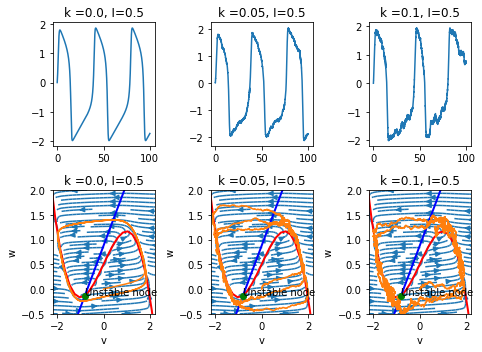

In [117]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0,0];
I=0.5

noises = [0.0, 0.05, 0.1];










fig1,axs1=plt.subplots(2,len(noises),figsize=(6.8,5)) #,figsize=(12,6)
#fig2,axs2=plt.subplots(1,len(noises),figsize=(12,3)) #,figsize=(12,6)


v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],I)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M




for i in range(len(noises)):
    
    

    
    axs1[1,i].streamplot(V1, W1, DV1, DW1)
    axs1[1,i].plot(v,w1(v,I),'r-', lw=2, label='first-nullcline')
    axs1[1,i].plot(v,w2(v,I),'b-', lw=2, label='second-nullcline')
    
    
    
    
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    
    axs1[0,i].plot(t,va)
    axs1[0,i].set_title("k ="+str(k1)+", I="+str(I))
    #axs1[1,i].plot(t,wa)
    #axs1[1,i].set_title("W for k ="+str(k1)+", I="+str(I))    
    
    
    axs1[1,i].plot(va,wa)
    axs1[1,i].set_title("k ="+str(k1)+", I="+str(I))
    
    
    
    
    
    roots=find_roots(I);
    for root in roots:
        label=stability(jacobian(root,I))
        #print(label)
        #print(root)
        axs1[1,i].plot(root[0],root[1],"go")
        axs1[1,i].annotate(label,root)
    
    
    
    axs1[1,i].set_xlim(-2.2,2.2)
    axs1[1,i].set_ylim(-0.5,2)
    axs1[1,i].set_xlabel('v')
    axs1[1,i].set_ylabel('w')
    

    
    
    
    
fig1.tight_layout()
#fig2.tight_layout()




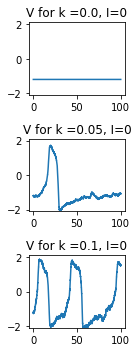

In [121]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
I=0
point=find_roots(I)[0]

noises = [0.0, 0.05, 0.1];










fig1,axs1=plt.subplots(len(noises),1,figsize=(2,5)) #,figsize=(12,6)
#fig2,axs2=plt.subplots(1,len(noises),figsize=(12,3)) #,figsize=(12,6)


v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],I)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M




for i in range(len(noises)):
    
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    
    axs1[i].plot(t,va)
    axs1[i].set_title("V for k ="+str(k1)+", I="+str(I))
    axs1[i].set_ylim(-2.1,2.1)
    #axs1[1,i].plot(t,wa)
    #axs1[1,i].set_title("W for k ="+str(k1)+", I="+str(I))    
       
plt.tight_layout()



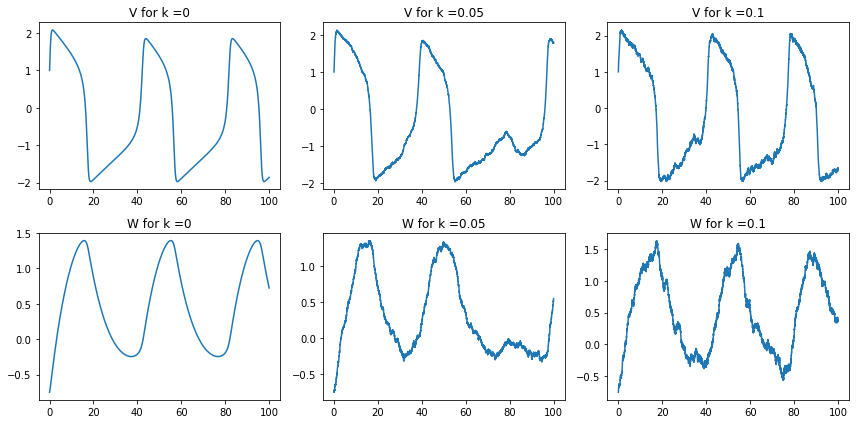

In [44]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[1,-0.75];
I=0.5

noises = [0, 0.05, 0.1];

fig,axs=plt.subplots(2,len(noises),figsize=(12,6)) #,figsize=(12,6)

for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    axs[0,i].plot(t,va)
    axs[0,i].set_title("V for k ="+str(k1))
    axs[1,i].plot(t,wa)
    axs[1,i].set_title("W for k ="+str(k1))
    
plt.tight_layout()


Stable node
[-1.1994080352440346, -0.6242600440550439]


Text(0, 0.5, 'V')

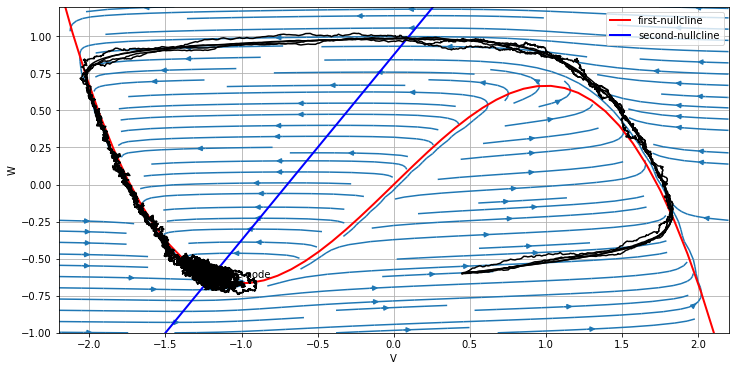

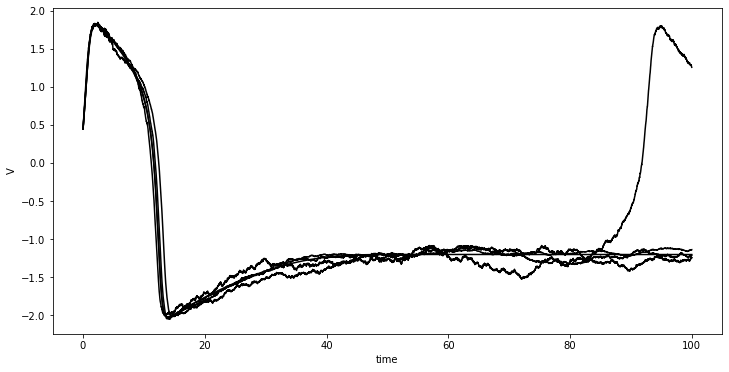

In [45]:
#so now, same general thing for noise levels
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(12,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)



    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('V')
plt.ylabel('W')







tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[0.45,-0.6];
I=0

noises = [0, 0.01, 0.02, 0.03, 0.04];


for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    ax4.plot(va,wa,'k-')
    











plt.xlabel('V')
plt.ylabel('W')


fig3 = plt.figure(figsize=(12,6))
ax5 = fig3.add_subplot(1,1,1)

for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    ax5.plot(t,va,'k-')
plt.xlabel('time')
plt.ylabel('V')



Stable node
[-1.1994080352440346, -0.6242600440550439]


Text(0, 0.5, 'V')

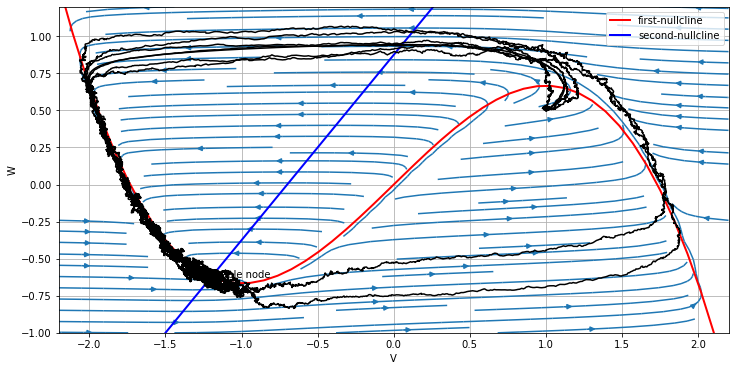

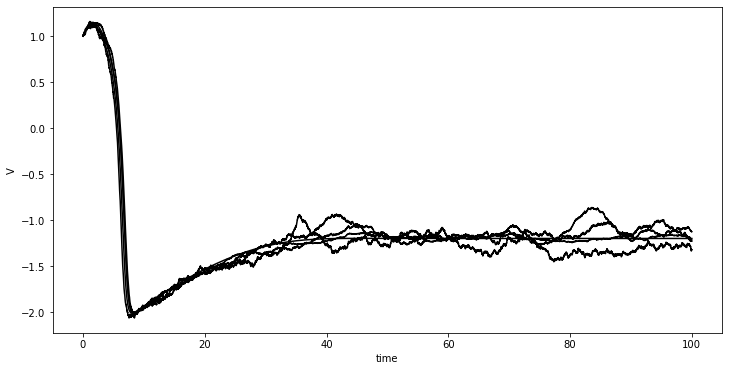

In [46]:
#so now, same general thing for noise levels
#for this, pick Iext
Iext=0;
t=np.arange(0.0, 100.0, 0.01);

fig2 = plt.figure(figsize=(12,6))
ax4 = fig2.add_subplot(1,1,1)

v=np.linspace(-2.2,2.2,50);
w=np.linspace(-1,1.2,50);



ax4.plot(v,w1(v,Iext),'r-', lw=2, label='first-nullcline')
ax4.plot(v,w2(v,Iext),'b-', lw=2, label='second-nullcline')

#tstop=450;
#dt=0.01
#t=np.arange(0.0, tstop, dt)
#neuron=FHNneuron(Iext,tstop,dt,[-0.7,0]);
#va=neuron[0];
#wa=neuron[1];
#ax4.plot(va,wa,'k-')

#ax4.plot([0,2],[2,0], 'r-', lw=2, label='x-nullcline') fill these in with the actual nullclines, found by hand???
#ax4.plot([1,1],[0,2], 'b-', lw=2, label='y-nullcline')

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],Iext)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M


tstop=100;
dt=0.01
t=np.arange(0.0, tstop, dt)



    
ax4.streamplot(V1, W1, DV1, DW1)
ax4.legend()
ax4.grid()

roots=find_roots(Iext);
for root in roots:

    label=stability(jacobian(root,Iext))
    print(label)
    print(root)
    plt.plot(root[0],root[1],"go")
    plt.annotate(label,root)

plt.xlim(-2.2,2.2)
plt.ylim(-1,1.2)
plt.xlabel('V')
plt.ylabel('W')







tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[1,0.5];
I=0

noises = [0, 0.01, 0.02, 0.03, 0.04];


for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    ax4.plot(va,wa,'k-')
    











plt.xlabel('V')
plt.ylabel('W')


fig3 = plt.figure(figsize=(12,6))
ax5 = fig3.add_subplot(1,1,1)

for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    ax5.plot(t,va,'k-')
plt.xlabel('time')
plt.ylabel('V')



[]
[1509 7977]
[1649 4792 8143]
[1397 9469]
[1123 5867 8027]


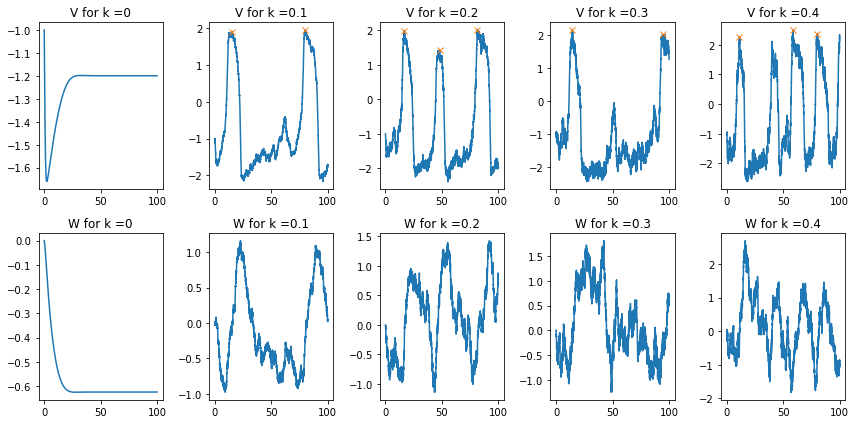

In [47]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
point=[-1,0];
I=0

noises = [0, 0.1, 0.2, 0.3, 0.4];

fig,axs=plt.subplots(2,len(noises),figsize=(12,6)) #,figsize=(12,6)

for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    axs[0,i].plot(t,va)
    axs[0,i].set_title("V for k ="+str(k1))
    axs[1,i].plot(t,wa)
    axs[1,i].set_title("W for k ="+str(k1))
    peaks, _ = find_peaks(va, height=1,distance=2000)
    axs[0,i].plot(t[peaks],va[peaks],"x")
    print(peaks)
plt.tight_layout()


Text(0, 0.5, 'Misfires per Unit Time')

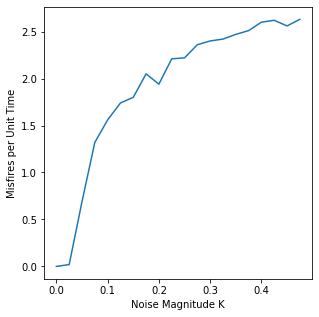

In [124]:
tstop=1000;
dt=0.01;
t=np.arange(0.0, tstop, dt)
I=0
point=find_roots(I)[0];


noises = np.arange(0.0,0.5,0.025)  #[0, 0.1, 0.2, 0.3, 0.4];

#fig,axs=plt.subplots(2,len(noises),figsize=(12,6)) #,figsize=(12,6)
iterations=10
data=[]
for i in range(len(noises)):
    k1=noises[i]
    k2=k1
    count=0
    numpeakvec=[]
    while count < iterations:
        count+=1
        neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
        va=neuron[0];
        wa=neuron[1];
        peaks, _ = find_peaks(va, height=1,distance=2000)
        numpeakvec.append(len(peaks))
    npeakav=np.average(numpeakvec)
    #print(npeakav)
    data.append(100*npeakav/tstop)

plt.figure(figsize=(4.8,5))
plt.plot(noises,data)
plt.xlabel('Noise Magnitude K')
plt.ylabel('Misfires per Unit Time')


In [49]:
data

[0.0,
 0.07,
 0.79,
 1.34,
 1.63,
 1.82,
 1.9899999999999998,
 1.97,
 2.13,
 2.16,
 2.3,
 2.45,
 2.38,
 2.57,
 2.55,
 2.55,
 2.55,
 2.54,
 2.63,
 2.65]

In [50]:
noises[3]

0.07500000000000001

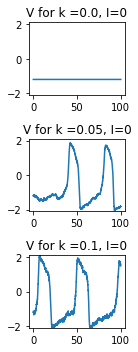

In [122]:
tstop=100;
dt=0.01;
t=np.arange(0.0, tstop, dt)
I=0
point=find_roots(I)[0]

noises = [0.0, 0.05, 0.1];










fig1,axs1=plt.subplots(len(noises),1,figsize=(2,5)) #,figsize=(12,6)
#fig2,axs2=plt.subplots(1,len(noises),figsize=(12,3)) #,figsize=(12,6)


v=np.linspace(-2.5,2.5,25);
w=np.linspace(-0.5,2,25);

V1, W1 = np.meshgrid(v, w)
DV1, DW1 = Syst([V1, W1],I)
M = (np.hypot(DV1, DW1))
M[ M == 0] = 1.
DV1 /= M
DW1 /= M




for i in range(len(noises)):
    
    k1=noises[i]
    k2=k1
    neuron=FHNneuronNoisy(I,tstop,dt,point,k1,k1);
    va=neuron[0];
    wa=neuron[1];
    
    axs1[i].plot(t,va)
    axs1[i].set_title("V for k ="+str(k1)+", I="+str(I))
    axs1[i].set_ylim(-2.1,2.1)
    #axs1[1,i].plot(t,wa)
    #axs1[1,i].set_title("W for k ="+str(k1)+", I="+str(I))    
       
plt.tight_layout()

